# West Nile Virus Predictions

1. What factors appear to be the drivers of mosquito population of West Nile Virus presence
2. How can my model with an understanding of driving factors be used to inform actions in Chicago
3. What evaluations metrics and strategies are appropriate
4. What additonal data might be relevant for understanding the problem
5. What pitfalls, if not addressed, would significantly impair the usefulness of the model

## TODO

1. Reindex the weather_data after dropping station 2. 

# Basic Imports

In [513]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
from tqdm import tqdm
from scipy.stats import norm

import folium
import branca
import folium.plugins
import branca.colormap as cm

from pprint import pprint
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# Defining Functions

In [526]:
def unique_lat_lon(row):
    """
    Takes in a row from the mosquito dataframe and then replaces the lat and lon values
    for each trap number with the mean value for that trap number. This removes duplicate
    lat long entries for the same trap location
    """
    row['Latitude'] = mean_lat[row['Trap']]
    row['Longitude'] = mean_lon[row['Trap']]
    return row


def calculate_ratio_positives_pvalue(row):
    """
    takes in a row from the by_trap_df and calculates the test statistic (assuming the
     mean in normally distributed)
    """
    n = row['num_measurements']
    if n < 30:
        return np.nan
    mu_star = 0.052446
    mu = row['ratio_positives']
    sigma = row['std_positives']
    Tn = np.sqrt(n)*(mu-mu_star)/(sigma)
    if Tn < 1.28:
        return np.nan
    else:
        return 1-norm.cdf(Tn)

# Reading in files

In [570]:
weather_data = pd.read_csv('./weather.csv')
mosquito_data = pd.read_csv('./train.csv')

Let us examine the datatypes of the various columns to see if we need to make any data type conversions

In [4]:
weather_data.dtypes

Station          int64
Date            object
Tmax             int64
Tmin             int64
Tavg            object
Depart          object
DewPoint         int64
WetBulb         object
Heat            object
Cool            object
Sunrise         object
Sunset          object
CodeSum         object
Depth           object
Water1          object
SnowFall        object
PrecipTotal     object
StnPressure     object
SeaLevel        object
ResultSpeed    float64
ResultDir        int64
AvgSpeed        object
dtype: object

A visual exploration of the datasets suggests a few data preliminary cleaning and processing steps:

1. The `CodeSum` column is a collection of significant weather events such as tornados or thundershowers. We will be arranging this column alphabetically and then one hot encoding this columns - perhaps these significant weather events are predictive. 

2. There are a large number of correlated variables. For example the data and the sunrise and sunset variables. It might be worth looks at correlation plots and then also finding variation inflation factors to see how much correlation there is between variables and make decisions on which ones to drop.

3. This is data only for summer months, so it seems that any data involving snowfall or ice can be dropped. Comparing the weather data to the NOAA explanation of the columns, this seems to suggest that `Depth`, `Water1` and `Snowfall` can be dropped.

4. Look at the correlation plot between station 1 and station 2 for all variables across all dates. Maybe the simplest thing to do is to just plot various quantities as a function of time and have a big page of different features and show how all varaibles basically track each other. Then make a choice on which stations data to drop. Maybe also calculate correlation coefficients for each variable across two stations (like a time series correlation) and then justify the choice to drop a station.

5. Ultimately, we are going to merge the mosquitos dataset with the weather dataset based on date, but before that we will individually cleaning the datasets. 

# Cleaning the datasets

We now drop a few columns by making a few assumptions. First, we drop snowfall parameters such as `Depth`, `Water1` and `SnowFall` because they are irrelvant for the data consisting only of summer months when mosquitos are active. We also drop degree days columns `Heat` and `Cool` because these are linearly correlated with `Tavg` because they are measured as an offset from `Tavg`.

In [5]:
# First drop the snow related columns because they are not of relevance for summer months
weather_data = weather_data.drop(columns=['Depth', 'Water1', 'SnowFall', 'Heat', 'Cool'])

### Justification for why I am dropping weather data from Station 2 (Cleanup the plots)

I see that for each date, there are weather recordings from two different stations. It is likely that if the data from the two stations are accurate, then these data are also likely to be strongly correlated. We check this assumption by first splitting the dataframe into two (one for each station) and then check the correlation between corresponding columns in the two tables.

In [6]:
weather_data_station1 = weather_data[weather_data['Station'] == 1]
weather_data_station2 = weather_data[weather_data['Station'] == 2]

Next, we create a massive line plot of each numerical feature in the station 1 table and the station 2 table as a function of date and visually inspect the two plots. If the time series plots of the two stations closely track each other, it means that we have some redundancy in terms of having data from two stations, we will drop one of the stations. It turns out that station two has no `Depart` data, and has no `Sunrise` and `Sunset` data, so we will use Station 1 data in case there is strong correlation and redundancy between the tables. 

In [7]:
avgspeed1 = weather_data_station1['AvgSpeed'].astype(np.float)
avgspeed2 = np.array([0 if x == 'M' else x for x in weather_data_station2['AvgSpeed']]).astype(np.float)

# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(30,7))
# ax.plot_date(weather_data_station1['Date'][::5], avgspeed1[::5], xdate=True, fmt='-')
# ax.plot_date(weather_data_station2['Date'][::5], avgspeed2[::5], xdate=True, fmt='-')
# plt.xticks(rotation='vertical');

print(np.corrcoef(avgspeed1, avgspeed2)[0,1])
print(np.corrcoef(weather_data_station1['Tmax'], weather_data_station2['Tmax'])[0,1])
print(np.corrcoef(weather_data_station1['Tmin'], weather_data_station2['Tmin'])[0,1])
print(np.corrcoef(weather_data_station1['DewPoint'], weather_data_station2['DewPoint'])[0,1])

0.9455136610835704
0.9868963514443369
0.9778813646416583
0.9897128976242204


In [8]:
# plot of Tmax vs Date for the two stations
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(30,7))
# ax.plot_date(weather_data_station1['Date'][::5], weather_data_station1['Tmax'][::5], xdate=True, fmt='-')
# ax.plot_date(weather_data_station2['Date'][::5], weather_data_station2['Tmax'][::5], xdate=True, fmt='-')
# plt.xticks(rotation='vertical');

In [9]:
# plot of Tmin vs Date for the two stations
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(30,7))
# ax.plot_date(weather_data_station1['Date'][::5], weather_data_station1['Tmin'][::5], xdate=True, fmt='-')
# ax.plot_date(weather_data_station2['Date'][::5], weather_data_station2['Tmin'][::5], xdate=True, fmt='-')
# plt.xticks(rotation='vertical');

In [10]:
# plot of DewPoint vs Date for the two stations
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(30,7))
# ax.plot_date(weather_data_station1['Date'][::5], weather_data_station1['DewPoint'][::5], xdate=True, fmt='-')
# ax.plot_date(weather_data_station2['Date'][::5], weather_data_station2['DewPoint'][::5], xdate=True, fmt='-')
# plt.xticks(rotation='vertical');

Because of the high correlation between the the two stations and the fact station 2 has more missing data, we will go ahead and only use the data from station 1

In [11]:
weather_data = weather_data_station1.drop(columns='Station')

In [12]:
weather_data.dtypes

Date            object
Tmax             int64
Tmin             int64
Tavg            object
Depart          object
DewPoint         int64
WetBulb         object
Sunrise         object
Sunset          object
CodeSum         object
PrecipTotal     object
StnPressure     object
SeaLevel        object
ResultSpeed    float64
ResultDir        int64
AvgSpeed        object
dtype: object

We are interested in transforming as many columns as possible into numeric columns to supply a predictive model. In some cases, we the columns are just strings for no reasons. In other cases, there are string identifiers for missing data or null values. First we convert as many values to numerical as possible, and then we deal with the columns with missing values. For the precipitation, we are going to replace all the T values with the mean of 0 and the smallest detectable value (0.01) = 0.005.

We notice that 55% of all the data in this column is empty (' '), so we will first fill all the empty values with 'NA' (to mean that there was no special weather conditions).

In [13]:
# Convert as many features to numerical types as possible
weather_data['Tavg'] = weather_data['Tavg'].astype(np.int64)
weather_data['Depart'] = weather_data['Depart'].astype(np.int64)
weather_data['AvgSpeed'] = weather_data['AvgSpeed'].astype(np.float)

# Replace trace with the average of 0 and the smallest detectable value, then convert to numeric.
weather_data['PrecipTotal'] = weather_data['PrecipTotal'].apply(lambda val: 0.005 if val == '  T' else val).astype(np.float)

# Replace ' ' in the CodeSum column with 'NA'.

weather_data['CodeSum'] = np.where(weather_data['CodeSum'] == ' ', 'NA', weather_data['CodeSum'])


# Baseline model

We plan to do detailed feature engineering, evaluation and feature selection, but to check the impact and benefit of that feature engineering, we first need to define a baseline model with minimal basic data cleaning and munging operations so that we can evaluate the performance of our feature engineering. We first copy the weather data over. 

In [14]:
weather_data_baseline = deepcopy(weather_data)
weather_data_baseline.dtypes

Date            object
Tmax             int64
Tmin             int64
Tavg             int64
Depart           int64
DewPoint         int64
WetBulb         object
Sunrise         object
Sunset          object
CodeSum         object
PrecipTotal    float64
StnPressure     object
SeaLevel        object
ResultSpeed    float64
ResultDir        int64
AvgSpeed       float64
dtype: object

## Backfilling missing values ('M') using the persistence model

Like I mentioned earlier, my goal is to convert as many of the columns as possible into numerical data types (where appropriate) so that I can evaluate to see if it is an important feature or not. There are some still some columns that are of type `object` because there are some missing values that are indicated by the value 'M'. We will remove these values, replace with an appropriate numerical value and then convert the entire column to a numerical type (where appropriate).

The strategy we take here is to fill each 'M' value with the same value as the previous day. This is sometimes called the persistence model; this is appropriate use for this model because weather changes only once every 3 days, so on any given day, it is more likely that the weather is the same as the previous day that is is different from the previous day. Later, we will examine more sophisticated ways to perform data imputation. This imputation process proceeds in two steps:

1. First replace 'M' values with `np.nan`
2. Backfill the `np.nan` values using values from the previous day (the persistence model)

In [15]:
# backfill WetBulb
weather_data_baseline['WetBulb'] = (weather_data_baseline['WetBulb'].replace(to_replace='M', value=np.nan))
weather_data_baseline['WetBulb'] = (weather_data_baseline['WetBulb'].fillna(method='backfill')).astype(np.int64)

# backfill StnPressure
weather_data_baseline['StnPressure'] = (weather_data_baseline['StnPressure'].replace(to_replace='M', value=np.nan))
weather_data_baseline['StnPressure'] = (weather_data_baseline['StnPressure'].fillna(method='backfill')).astype(np.float)

# backfill SeaLevel
weather_data_baseline['SeaLevel'] = (weather_data_baseline['SeaLevel'].replace(to_replace='M', value=np.nan))
weather_data_baseline['SeaLevel'] = (weather_data_baseline['SeaLevel'].fillna(method='backfill')).astype(np.float)

### Dealing with the `CodeSum` column

The `CodeSum` column is very rich with information because it encodes special event conditions such as tornadoes and thundershowers which can influence many things such as standing water, humidity, etc. Instead of having strings, and remove the dependence on the ordering of strings, we first split the string into a list, then order alphabetically (so that the days with the same weather conditions but with different ordering of CodeSum do not appear to be different), and finally, we one-hot-encode the column so that we can convert it into a numerical column. 

In [16]:
# Split and Sort the CodeSum column
weather_data_baseline['CodeSum'] = (
    weather_data_baseline['CodeSum'].apply(lambda s: sorted(s.split()))
    )

Now, when find the number of unique entries we have, it turns out that we have 67 unique entries! So in the naive, baseline model, we are going to add 67 dummy columns to the dataframe i.e. for each weather condition, we have a separate column, and we mark that particular column 0 if a certain weather condition exists in CodeSum and 1 if it does not exist.

In [17]:
# First find all the unique entries

codesum_entries = []
for l in weather_data_baseline['CodeSum']:
    codesum_entries.extend(l)
unique_codesum_entries = list(set(codesum_entries)) # There are only 15 unique CodeSum entires, but many more combinations of the various entries.

We find that there are 15 unique `CodeSum` entries, so this will dictate the names of the dummy columns. We first add the columns for each unique weather phenomenon.

In [18]:
# first all the dummy columns into the dataframe
l = len(weather_data_baseline.columns)
r = weather_data_baseline.shape[0]
for entry in unique_codesum_entries:
    weather_data_baseline.insert(loc=l, column=entry, value=np.zeros(r, dtype=np.int64))

In [20]:
# Let's now add dummy columns the slow way. We will be making multiple passes through the dataframe for each entry

# for entry in tqdm(unique_codesum_entries):
#     for i in range(weather_data_baseline.shape[0]):
#         row = weather_data_baseline.iloc[i]
#         codesum = row['CodeSum']
#         row[entry] = (entry in codesum)*1
#         weather_data_baseline.iloc[i] = row
# tqdm.pandas()
# for entry in unique_codesum_entries:
#     weather_data_baseline.apply(lambda row: codesum_phenomenon(entry, row), axis=1)

# weather_data_baseline.to_pickle('./weather_data_baseline.pkl')


100%|██████████| 15/15 [13:53<00:00, 56.54s/it]


In [25]:
weather_data_baseline = pd.read_pickle('./weather_data_baseline.pkl')

# EDA on the mosquito data

Similar to the weather data case, I now want to have dummy columns to encode the species of mosquito. This might come in handy later when thinking about whether there is higher incidence of WN in a particular mosquito species.

Preliminary examination gives us the following unique species: ['ERRATICUS', 'PIPIENS', 'RESTUANS', 'SALINARIUS', 'TARSALIS', 'TERRITANS']

In [571]:
species_columns = ['ERRATICUS', 'PIPIENS', 'RESTUANS', 'SALINARIUS', 'TARSALIS', 'TERRITANS']

r = mosquito_data.shape[0]
for species in species_columns:
    mosquito_data.insert(loc=3, column=species, value=np.zeros(r, dtype=np.int64))
    mosquito_data[species] = mosquito_data['Species'].apply(lambda entry: species in entry)*1

In [572]:
mosquito_data = mosquito_data.drop(columns='Species')

In [573]:
mosquito_data.columns

Index(['Date', 'Address', 'TERRITANS', 'TARSALIS', 'SALINARIUS', 'RESTUANS',
       'PIPIENS', 'ERRATICUS', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent'],
      dtype='object')

Let us now do some basic EDA.

## Influence of trap number (or equivalently, location)

For this, we first group by trap number and then explore various features.

In [574]:
grouped_by_trap = mosquito_data.groupby(by='Trap')

A prelimiary exploration of the dataset indicates that in some cases, for the same trap number, there were two different GPS location, so for this, we will use the mean value for the lattiude and longitude and then update the dataframe.

In [575]:
mean_lat = grouped_by_trap['Latitude'].unique().apply(np.mean)
mean_lon = grouped_by_trap['Longitude'].unique().apply(np.mean)

mosquito_data = mosquito_data.apply(unique_lat_lon, axis=1)
mosquito_data.describe()

,TERRITANS,TARSALIS,SALINARIUS,RESTUANS,PIPIENS,ERRATICUS,Block,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
count,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000
mean,0.021131,0.000571,0.008186,0.713116,0.709214,0.000095,35.687797,41.841177,-87.699736,7.819532,12.853512,0.052446
std,0.143827,0.023892,0.090109,0.452328,0.454147,0.009756,24.339468,0.112645,0.096269,1.452921,16.133816,0.222936
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,41.644612,-87.930995,3.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,41.732984,-87.760070,8.000000,2.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,33.000000,41.846283,-87.696269,8.000000,5.000000,0.000000
75%,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,52.000000,41.954690,-87.627796,9.000000,17.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,98.000000,42.017430,-87.531635,9.000000,50.000000,1.000000


Next, we will calculate a series of metrics grouped by trap (i.e. a proxy for location) so that we can understand which areas need most resources from the city of Chicago

### Number of times a particular trap was sampled

Next, we want to see how often the different traps around the city were sampled. This information would help us see put in perspective any positive results for WNV sightings. Of course, traps that are sampled more frequently are more likely to have positive sightings. Moreover, knowing this information might also give us leads into which locations need sampling more often.

### Number of total WNV positives by trap

Here we calculate which traps have seen the most cases of WNV

### Normalized number of WNV positives by trap

Some traps are sampled more often than others, so to really understand the frequency of sightings, we really need to normalize the absolute number of sightings with the number of of times a certain trap was sampled.

In [522]:
number_measurements_by_trap = grouped_by_trap['Date'].count()
number_positives_by_trap = grouped_by_trap['WnvPresent'].sum()
std_positives_by_trap = grouped_by_trap['WnvPresent'].std()
num_mosquitos_by_trap = grouped_by_trap['NumMosquitos'].mean()

Fold everything into a dataframe called `by_trap_df`. 

In [523]:
by_trap_df = pd.DataFrame(columns=['Trap', 'num_measurements'])

by_trap_df['Trap'] = number_measurements_by_trap.index
by_trap_df['Latitude'] = mean_lat.values
by_trap_df['Longitude'] = mean_lon.values
by_trap_df['num_measurements'] = number_measurements_by_trap.values
by_trap_df['num_positives'] = number_positives_by_trap.values
by_trap_df['ratio_positives'] = by_trap_df['num_positives']/by_trap_df['num_measurements']
by_trap_df['std_positives'] = std_positives_by_trap.values
by_trap_df['num_mosquitos_avg'] = num_mosquitos_by_trap.values

In [524]:
by_trap_df.head()

,Trap,num_measurements,Latitude,Longitude,num_positives,ratio_positives,std_positives,num_mosquitos_avg
0,T001,15,41.953705,-87.733974,0,0.000000,0.000000,1.666667
1,T002,185,41.954690,-87.800991,18,0.097297,0.297166,20.054054
2,T003,122,41.964242,-87.757639,14,0.114754,0.320039,11.032787
3,T004,12,41.962728,-87.748367,0,0.000000,0.000000,4.916667
4,T005,14,41.942114,-87.776385,2,0.142857,0.363137,3.571429


### Plotting folium maps of number of measurements, num positives and ratio positives by location

The size in the map below corresponds to the number of measurents made and the color corresponds to the number of positive tests of WNV presence. We see a strong correlation between the number of measurements made and the number of positives, so we should really look at a normalized metric to dig into which locations are more problematic than others. In fact, there is a correlation co-efficient of 0.92. 

In [525]:
# num_measurements and num_positives

color_min = by_trap_df['num_positives'].min()
color_max = by_trap_df['num_positives'].max()
colormap = cm.LinearColormap(colors=['blue','red'],
                             index=[0, 23],
                             vmin=color_min,
                             vmax=color_max)
# colormap = cm.linear.OrRd
map_num_measurements = folium.Map(location=[by_trap_df['Latitude'].mean()-.07,
                              by_trap_df['Longitude'].mean()],
                              zoom_start=10)
folium.TileLayer('cartodbpositron').add_to(map_num_measurements)
mn = by_trap_df['num_measurements'].max()
by_trap_df.apply(lambda row: 
                    folium.CircleMarker(location=[row['Latitude'], row['Longitude']],
                                        radius=row['num_measurements']/mn*40,
                                        fill=True,
                                        stroke=False,
                                        color=colormap(row['num_positives']),
                                        # color='green',
                                        fill_opacity=1).add_to(map_num_measurements),
                 axis=1)
map_num_measurements

In [359]:
# Plotting ratio_positives

color_min = by_trap_df['ratio_positives'].min()
color_max = by_trap_df['ratio_positives'].max()
colormap = cm.LinearColormap(colors=['blue','red'],
                             index=[0, .8],
                             vmin=color_min,
                             vmax=color_max)

map_ratio_positives = folium.Map(location=[by_trap_df['Latitude'].mean()-.07,
                              by_trap_df['Longitude'].mean()],
                              zoom_start=10)
folium.TileLayer('cartodbpositron').add_to(map_ratio_positives)
mr = by_trap_df['ratio_positives'].max()
by_trap_df.apply(lambda row: 
                    folium.CircleMarker(location=[row['Latitude'], row['Longitude']],
                                        radius=6,
                                        fill=True,
                                        stroke=False,
                                        color=colormap(row['ratio_positives']/mr),
                                        fill_opacity=0.75).add_to(map_ratio_positives),
                 axis=1)
map_ratio_positives

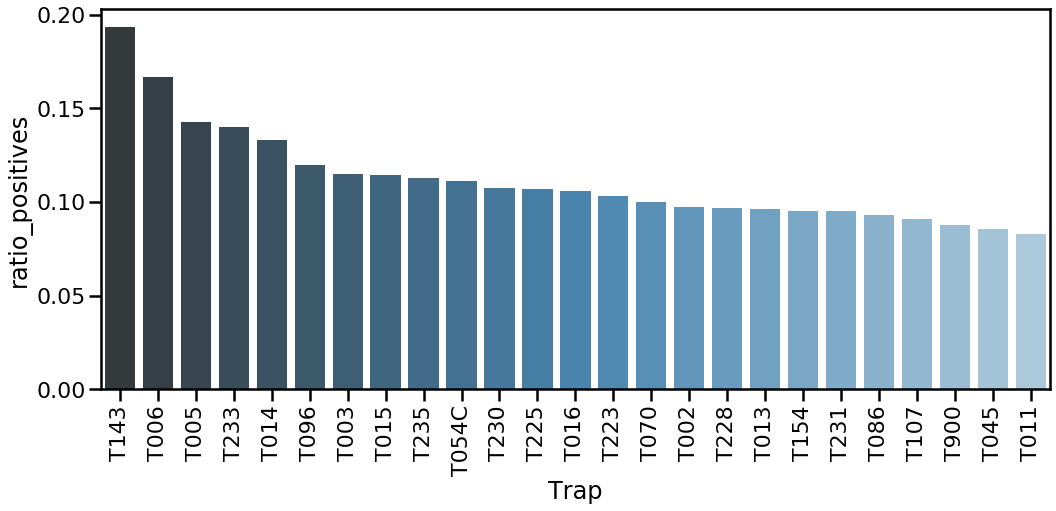

In [312]:
# Barplot of highest ratio of mosquito sightings
fig_ratio_positives, ax_ratio_positives = plt.subplots(nrows=1, ncols=1, figsize=(17,7))
ax_ratio_positives.set_xticklabels(labels=by_trap_df['Trap'], rotation=90)
ax_ratio_positives = sns.barplot(x='Trap', y='ratio_positives', data=by_trap_df.sort_values(by=['ratio_positives'], ascending=False)[:25], palette='Blues')
# sns.set_context('poster')

In [374]:
# sorting the dataframe by the ratio positives to see if the number of measurements is too low
by_trap_df['pvalue_ratio_positives'] = by_trap_df.apply(lambda row: calculate_ratio_positives_pvalue(row), axis=1)

In [409]:
by_trap_df.sort_values(by='ratio_positives', ascending=False)

,Trap,num_measurements,Latitude,Longitude,num_positives,ratio_positives,std_positives,num_mosquitos_avg,pvalue_ratio_positives
89,T143,31,41.999129,-87.795585,6,0.193548,0.401610,7.419355,0.025221
5,T006,24,41.990284,-87.797127,4,0.166667,0.380693,4.458333,NaN
4,T005,14,41.942114,-87.776385,2,0.142857,0.363137,3.571429,NaN
129,T233,50,42.009876,-87.807277,7,0.140000,0.350510,15.160000,0.038674
12,T014,30,41.970248,-87.787992,4,0.133333,0.345746,12.133333,0.100027
74,T096,50,41.731922,-87.677512,6,0.120000,0.328261,11.560000,0.072810
2,T003,122,41.964242,-87.757639,14,0.114754,0.320039,11.032787,0.015761
13,T015,35,41.974089,-87.824812,4,0.114286,0.322803,4.828571,NaN
130,T235,62,41.776428,-87.627096,7,0.112903,0.319058,8.983871,0.067847
40,T054C,9,41.925652,-87.633590,1,0.111111,0.333333,16.111111,NaN


In [527]:
# Plotting locations whose positive ratios are higher than the entire mean in statistically significant amount
by_trap_df_nonan = by_trap_df.dropna(axis=0)
minp = by_trap_df_nonan['pvalue_ratio_positives'].min()
maxp = by_trap_df_nonan['pvalue_ratio_positives'].max()
color_min = by_trap_df_nonan['ratio_positives'].min()
color_max = by_trap_df_nonan['ratio_positives'].max()
colormap = cm.LinearColormap(colors=['blue','red'],
                             index=[0, .2],
                             vmin=0,
                             vmax=1)

map_sig_ratio_positive = folium.Map(location=[by_trap_df['Latitude'].mean()-.07,
                              by_trap_df['Longitude'].mean()],
                              zoom_start=10)
folium.TileLayer('cartodbpositron').add_to(map_sig_ratio_positive)

by_trap_df_nonan.apply(lambda row: 
                    folium.CircleMarker(location=[row['Latitude'], row['Longitude']],
                                        radius=row['ratio_positives']*100,
                                        fill=True,
                                        stroke=False,
                                        color='red',
                                        popup=row['Trap'],
                                        fill_opacity=(1 - (row['pvalue_ratio_positives'] - minp)/(maxp-minp))).add_to(map_sig_ratio_positive),
                 axis=1)
map_sig_ratio_positive


KeyError: 'pvalue_ratio_positives'

In [364]:
# Plotting number_mosquitos_per_trap_average
map_num_mosquitos_avg= folium.Map(location=[by_trap_df['Latitude'].mean()-.07,
                              by_trap_df['Longitude'].mean()],
                              zoom_start=10)
folium.TileLayer('cartodbpositron').add_to(map_num_mosquitos_avg)
ma = by_trap_df['num_mosquitos_avg'].max()
by_trap_df.apply(lambda row: 
                    folium.CircleMarker(location=[row['Latitude'], row['Longitude']],
                                        radius=row['num_mosquitos_avg']/ma*20,
                                        fill=True,
                                        stroke=False,
                                        # color=colormap(row['ratio_positives']),
                                        color='blue',
                                        fill_opacity=.8).add_to(map_num_mosquitos_avg),
                 axis=1)
map_num_mosquitos_avg

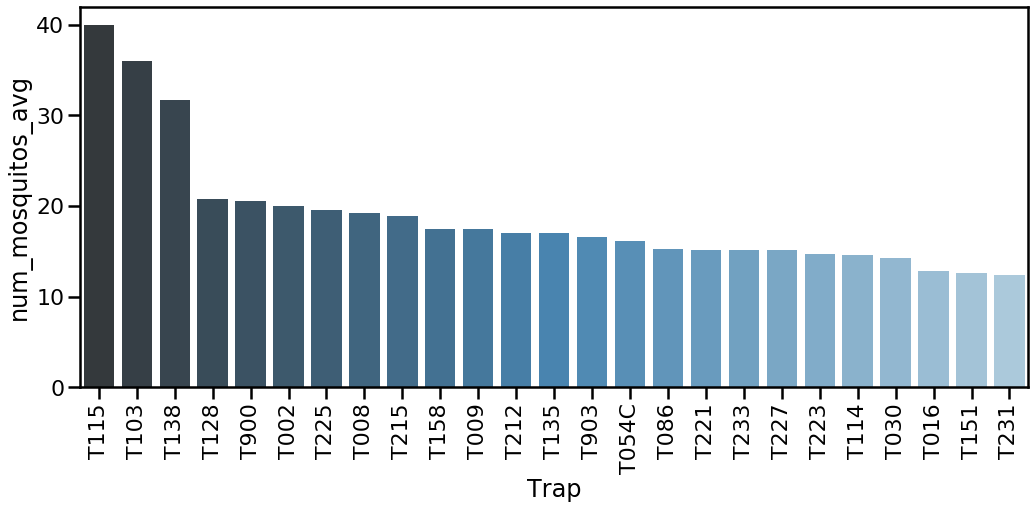

In [310]:
# Barplot of the highest average number of mosquitos per trap
# Barplot of highest ratio of mosquito sightings
fig_avg_mosquitos, ax_avg_mosquitos = plt.subplots(nrows=1, ncols=1, figsize=(17,7))
ax_avg_mosquitos.set_xticklabels(labels=by_trap_df['Trap'], rotation=90)
ax_avg_mosquitos = sns.barplot(x='Trap', y='num_mosquitos_avg', data=by_trap_df.sort_values(by=['num_mosquitos_avg'], ascending=False)[:25], palette='Blues_d')
# sns.set_context('poster')

### Influence of mosquito type

We have already looked at the influence of location and how that informs the presence of WNV. Another factor to explore is the mosquito species. Are some species more correlated with the presence of WNV than others? This might inform authorities to specially track or understand the distribution and behavioral patterns of that species for more effective control of WNV.

To do this, we take the naive approach at this stage and just look at a correlation matrix between the mosquito species and whether WNV was present or not.

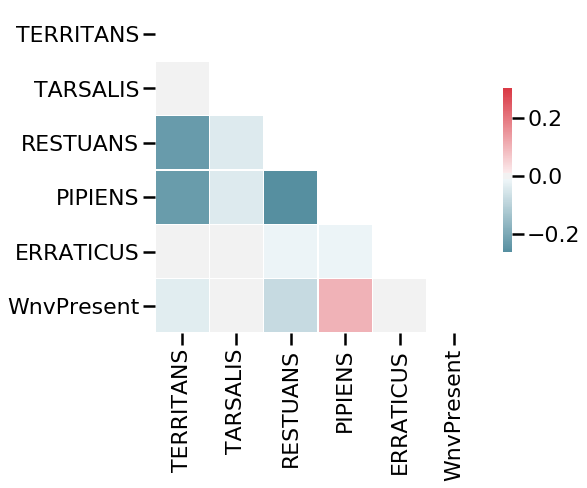

In [521]:
corr = (mosquito_data[['TERRITANS', 'TARSALIS', 'RESTUANS', 'PIPIENS', 'ERRATICUS', 'WnvPresent']]).corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(8, 6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

We next broup by mosquito to see how many sightings of different mosquito species were measured, and then find the normalized incidence of WNV i.e. for each mosquito column, we add up the total species sightings and then add up the total number of positive WNV sightings, and then find and plot the ratio

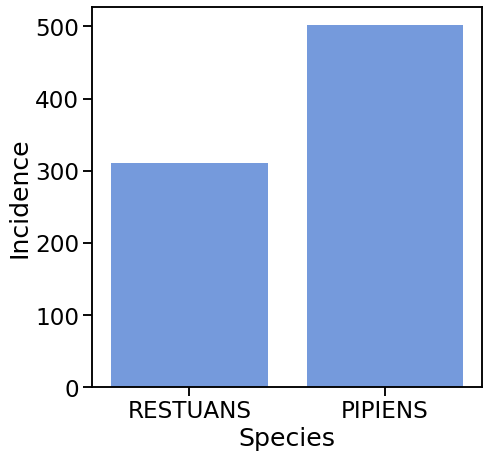

In [569]:
species = mosquito_data.columns[2:8]

mos_df = pd.DataFrame(columns=['Species', 'Incidence'])
# for i, mos in enumerate(species):
#     num_sightings = mosquito_data[mos].sum()
#     num_incidence = (mosquito_data[mosquito_data[mos] == 1]['WnvPresent']).sum()
#     mos_df.iloc[i]['Species'] = (num_sightings, num_incidence)
# mos_df['Species'] = mos_dict.keys()
# mos_df['Incidence'] = [tup[1] for tup in mos_dict.values()]
# mos_df = mos_df[mos_df['Incidence'] != 0]
# mos_df
for i, mos in enumerate(species):
    num_sightings = mosquito_data[mos].sum()
    num_incidence = (mosquito_data[mosquito_data[mos] == 1]['WnvPresent']).sum()
    if num_incidence != 0:
        mos_df = mos_df.append({'Species': mos, 'Incidence': num_incidence},
                               ignore_index=True)
mos_df
fig_mos, ax_mos = plt.subplots(nrows=1, ncols=1, figsize=(7,7))
ax_mos = sns.barplot(x='Species', y='Incidence', data=mos_df, color='cornflowerblue')

### Baseline model

For a baseline model, we are just going to use the mosquito information and see how well we are able to predict the incidence of WNV. For this, we only have access to species information and location information. I will be dropping the address information because that information is encoded in the GPS location.

One level feature engineering we will do here is to make sure we capture the month becuase this might be important (and WNV might be more active in certain times of the year). So we will also track the month, and use dummy variable encoding. Inspection of the data shows that the months for which we have mosquito data are from May through October.

The first thing we do is to just plot histograms to see if there are more cases of WNV in certain months. We will create a month column and then group by month and look at some statistics. We will also have to look at the number of inspections each month because the number of mosquitos caught as well as the number of cases of WNV will depend on how frequently the inspections and sampling was done. 

In [494]:
# First drop unnecessary columns
mosquito_data_lr = mosquito_data.drop(columns=['Address', 'Block', 'Street', 'AddressNumberAndStreet', 'AddressAccuracy'])

In [576]:
mosquito_data_lr.insert(loc=1, column='Month', value=np.zeros(mosquito_data.shape[0], dtype=np.int64))
mosquito_data_lr['Month'] = (mosquito_data_lr['Date'].apply(lambda date:date.split('-')[1])).astype(np.int64)
mosquito_data_lr[mosquito_data_lr['WnvPresent'] == 1]

ValueError: cannot insert Month, already exists

In [496]:
# Group by month and then look at some statistics
grouped_by_month = mosquito_data_lr.groupby('Month')
grouped_by_month['Month'].count()
by_month_df = pd.DataFrame(columns=['Month', 'num_measurements', 'total_mosquitos', 'total_incidence'])

In [497]:
by_month_df['Month'] = grouped_by_month['Month'].count().index
by_month_df['num_measurements'] = grouped_by_month['Month'].count().values
by_month_df['total_mosquitos'] = grouped_by_month['NumMosquitos'].sum().values
by_month_df['total_incidence'] = grouped_by_month['WnvPresent'].sum().values


In [498]:
by_month_df['incidence_ratio'] = by_month_df['total_incidence']/by_month_df['total_mosquitos']*100

In [499]:
by_month_df

,Month,num_measurements,total_mosquitos,total_incidence,incidence_ratio
0,5,84,230,0,0.000000
1,6,1571,16578,1,0.006032
2,7,2606,37248,46,0.123497
3,8,3751,58036,377,0.649597
4,9,2218,21029,125,0.594417
5,10,276,1918,2,0.104275


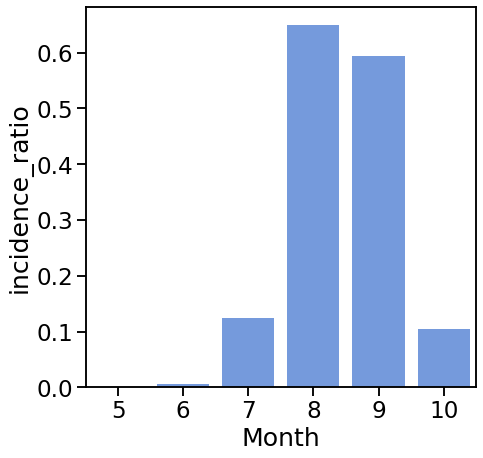

In [543]:
sns.set_context("talk", font_scale=1.4)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,7))
ax = sns.barplot(x='Month', y='incidence_ratio', data=by_month_df, color='cornflowerblue')

Because there is a strong dependence between month and incidence, we will, like before, generate dummy variables for each month as features in our model

In [501]:
months = ['May', 'June', 'July', 'August', 'September', 'October']
loc = 2
base_month = 5
z = np.zeros(mosquito_data_lr.shape[0], dtype=np.int64)
for month in months:
    mosquito_data_lr.insert(loc=loc, column=month, value=z)
    mosquito_data_lr[month] = (mosquito_data_lr['Month'] == base_month)*1
    loc += 1
    base_month += 1

In [506]:
mosquito_data_lr = mosquito_data_lr.drop(columns=['Date', 'Trap'])

KeyError: "['Date' 'Trap'] not found in axis"

We are now ready to run a baseline model. We will use Logistic Regression as a first pass, and examine some of the properties of the model and compare against some metrics

In [515]:
cols = mosquito_data_lr.columns
X = mosquito_data_lr[cols[:-1]]
y = mosquito_data_lr[cols[-1]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
print(f'The test accuracy is {accuracy_score(y_predict, y_test)}')

The test accuracy is 0.9571836346336822


ROC AUC=0.8010437375745527


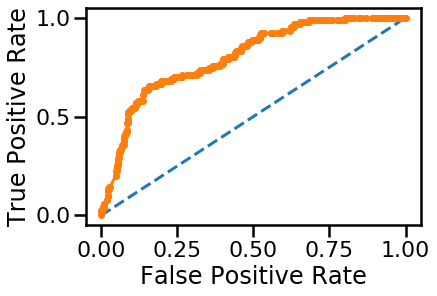

In [520]:
# Plotting the ROC curve
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = clf.predict_proba(X_test)
lr_probs = lr_probs[:, 1]

ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
print(f'ROC AUC={lr_auc}')

Already, just with the month and locaiton data, we are able to predict the incidence of WNV with high accuracy (96%) and with reasonably good ROC AUC (0.80). However, the performance can be better: I am not really hugging the y-axis. We can perhaps do better by including the weather data. For now, let us examine what the model does well and what it does poorly. What is worse? False positives or False negatives? Where is it doing worse?